# TITLE PENDING
### Bachelor's thesis by Lukas Schießer

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats

### Preprocessing

In [2]:
pd.options.display.max_columns = None
os.getcwd()
os.chdir("C:/code/Uni/ba/blood-exams")
data = pd.read_excel('covid_study_v2.xlsx')

In [3]:
data.insert(0,'male',data["GENDER"] == "M")
data.insert(0,'female',data["GENDER"] == "F")
data.drop(columns="GENDER", inplace=True)
data['Lymphocytes'] = pd.to_numeric(data['Lymphocytes'], errors='coerce')
data.loc[data["AGE"] < 18, "AGE"] = np.NaN
data.head()

,female,male,AGE,WBC,Platelets,Neutrophils,Lymphocytes,Monocytes,Eosinophils,Basophils,CRP,AST,ALT,ALP,GGT,LDH,SWAB
0,False,True,56.0,2.9,128.0,1.9,0.8,0.2,0.0,0.0,29.0,36.0,18.0,43.0,21.0,257.0,1
1,False,True,56.0,3.5,151.0,2.1,0.9,0.4,0.0,0.0,16.5,25.0,14.0,50.0,17.0,207.0,1
2,False,True,72.0,4.6,206.0,NaN,NaN,NaN,NaN,NaN,193.7,31.0,22.0,NaN,NaN,NaN,1
3,False,True,72.0,16.5,316.0,14.0,1.2,0.3,0.0,0.0,318.7,96.0,33.0,80.0,42.0,651.0,1
4,False,True,77.0,4.9,198.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [4]:
data.describe()

,AGE,WBC,Platelets,Neutrophils,Lymphocytes,Monocytes,Eosinophils,Basophils,CRP,AST,ALT,ALP,GGT,LDH,SWAB
count,277.000000,277.000000,277.000000,209.000000,208.000000,209.000000,209.000000,208.000000,273.000000,277.000000,266.000000,131.000000,136.000000,194.000000,279.000000
mean,61.776173,8.553069,226.532130,6.200478,1.186538,0.605742,0.055024,0.014423,90.889011,54.202166,44.917293,89.893130,82.477941,380.448454,0.634409
std,17.815695,4.855353,101.174178,4.172581,0.806442,0.410049,0.132237,0.039116,94.421406,57.612797,45.503232,89.089864,132.702506,193.983520,0.482461
min,18.000000,1.100000,20.000000,0.500000,0.200000,0.000000,0.000000,0.000000,0.100000,11.000000,9.000000,34.000000,10.000000,98.000000,0.000000
25%,49.000000,5.100000,163.000000,3.500000,0.700000,0.400000,0.000000,0.000000,21.400000,27.000000,21.000000,57.500000,23.750000,243.250000,0.000000
50%,64.000000,7.100000,205.000000,5.100000,1.000000,0.500000,0.000000,0.000000,54.200000,36.000000,31.000000,71.000000,41.000000,328.000000,1.000000
75%,76.000000,10.700000,271.000000,7.500000,1.400000,0.700000,0.100000,0.000000,129.100000,60.000000,46.000000,90.000000,83.000000,454.500000,1.000000
max,98.000000,29.200000,620.000000,26.400000,7.200000,3.200000,1.300000,0.300000,478.000000,550.000000,335.000000,838.000000,839.000000,1195.000000,1.000000


In [5]:
alpha = 0.05
for col in data.columns[2:-1]:
    # TODO: Perform a Shapiro-Wilk normality test
    stat, p = stats.shapiro(data[col].dropna())

    print('{}: stat={:0.3f}, p={:0.3f}; {}'.format(col, stat, p, 'Probably Normal' if p > alpha else 'Probably not Normal'))

AGE: stat=0.976, p=0.000; Probably not Normal
WBC: stat=0.873, p=0.000; Probably not Normal
Platelets: stat=0.930, p=0.000; Probably not Normal
Neutrophils: stat=0.838, p=0.000; Probably not Normal
Lymphocytes: stat=0.785, p=0.000; Probably not Normal
Monocytes: stat=0.811, p=0.000; Probably not Normal
Eosinophils: stat=0.457, p=0.000; Probably not Normal
Basophils: stat=0.395, p=0.000; Probably not Normal
CRP: stat=0.836, p=0.000; Probably not Normal
AST: stat=0.556, p=0.000; Probably not Normal
ALT: stat=0.629, p=0.000; Probably not Normal
ALP: stat=0.420, p=0.000; Probably not Normal
GGT: stat=0.500, p=0.000; Probably not Normal
LDH: stat=0.877, p=0.000; Probably not Normal


In [6]:
stat, p = stats.shapiro(data.dropna())
print('stat={:0.3f}, p={:0.3f}; {}'.format(stat, p, 'Probably Normal' if p > alpha else 'Probably not Normal'))

stat=0.570, p=0.000; Probably not Normal


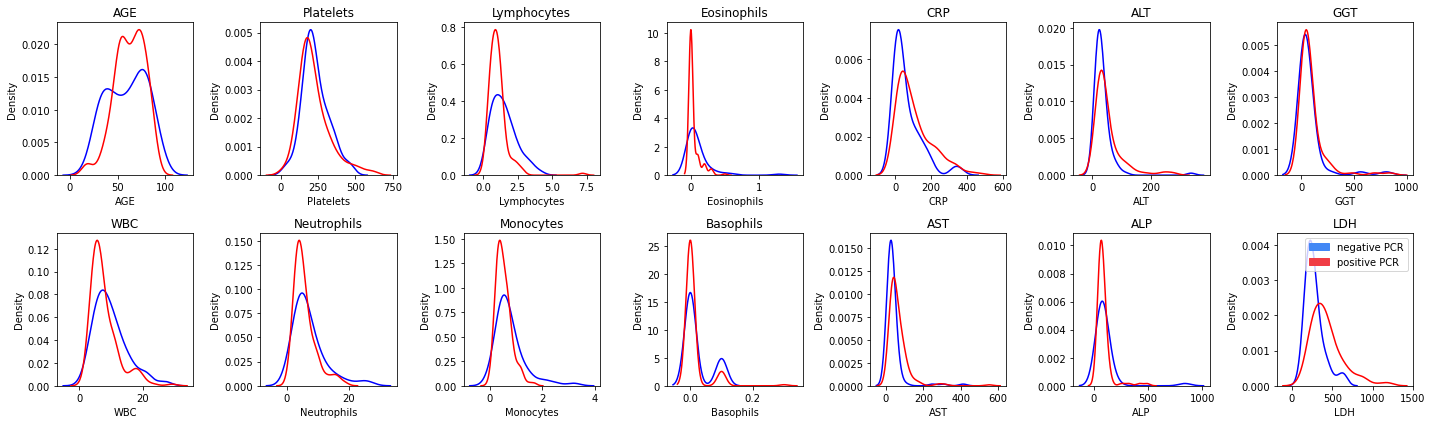

In [7]:
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='#4287f5', label='negative PCR')
red_patch = mpatches.Patch(color='#f03c45', label='positive PCR')
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(20,6))
for x in range(2,16):
    i = x % 2
    j = x // 2 - 1
    sns.kdeplot(data[data["SWAB"] == 0][data.columns[x]], ax=axes[i,j], color="blue")
    sns.kdeplot(data[data["SWAB"] == 1][data.columns[x]], ax=axes[i,j], color="red")
    axes[i,j].set_title(data.columns[x])
plt.legend(handles=[blue_patch, red_patch])
plt.tight_layout()

As you can see, most of the blood values do not follow a standard normal distribution. This can impact the imputation process negatively since most implementations of MICE assume MAR (missing at random) and normality regarding the variables.

In [8]:
data.skew(axis=0, skipna=True)

female         0.745619
male          -0.745619
AGE           -0.364711
WBC            1.465149
Platelets      1.117437
Neutrophils    1.856380
Lymphocytes    2.844919
Monocytes      2.428393
Eosinophils    5.129964
Basophils      3.233118
CRP            1.474657
AST            4.610819
ALT            3.361072
ALP            5.893664
GGT            3.977782
LDH            1.556878
SWAB          -0.561202
dtype: float64

In [11]:
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
min_val = np.zeros(len(data.columns))
imp = IterativeImputer(missing_values=np.nan, min_value = min_val, random_state=1)
imp_data = imp.fit_transform(data)

C:\Users\lukas\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [12]:
imp_data = pd.DataFrame(imp_data, columns=data.columns)
imp_data.describe()

,female,male,AGE,WBC,Platelets,Neutrophils,Lymphocytes,Monocytes,Eosinophils,Basophils,CRP,AST,ALT,ALP,GGT,LDH,SWAB
count,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000
mean,0.326165,0.673835,61.775767,8.548970,226.525014,6.620816,1.222327,0.638898,0.057638,0.016201,90.901415,54.174344,46.947604,83.175830,78.897189,377.446788,0.634409
std,0.469651,0.469651,17.751529,4.838367,100.835667,4.468135,0.729939,0.387556,0.118414,0.035431,93.455431,57.406226,47.940661,69.773036,110.055575,176.497315,0.482461
min,0.000000,0.000000,18.000000,1.100000,20.000000,0.500000,0.200000,0.000000,0.000000,0.000000,0.100000,11.000000,9.000000,0.000000,0.000000,98.000000,0.000000
25%,0.000000,0.000000,49.000000,5.100000,163.500000,3.673168,0.743929,0.400000,0.000000,0.000000,21.800000,27.000000,22.000000,58.800657,27.000000,266.288156,0.000000
50%,0.000000,1.000000,64.000000,7.200000,205.000000,5.300000,1.100000,0.594515,0.000000,0.000000,56.800000,37.000000,33.000000,73.000000,48.282975,335.836458,1.000000
75%,1.000000,1.000000,76.000000,10.700000,271.000000,8.281855,1.498433,0.800000,0.100000,0.010395,128.600000,60.000000,47.000000,87.904767,89.766505,437.000000,1.000000
max,1.000000,1.000000,98.000000,29.200000,620.000000,26.400000,7.200000,3.200000,1.300000,0.300000,478.000000,550.000000,335.000000,838.000000,839.000000,1195.000000,1.000000


When looking at the minima of the imputed datasets, it's noticeable that some of them are below zero which is not possible for any blood value. Therefore, the imputation model must be examined and adjusted.

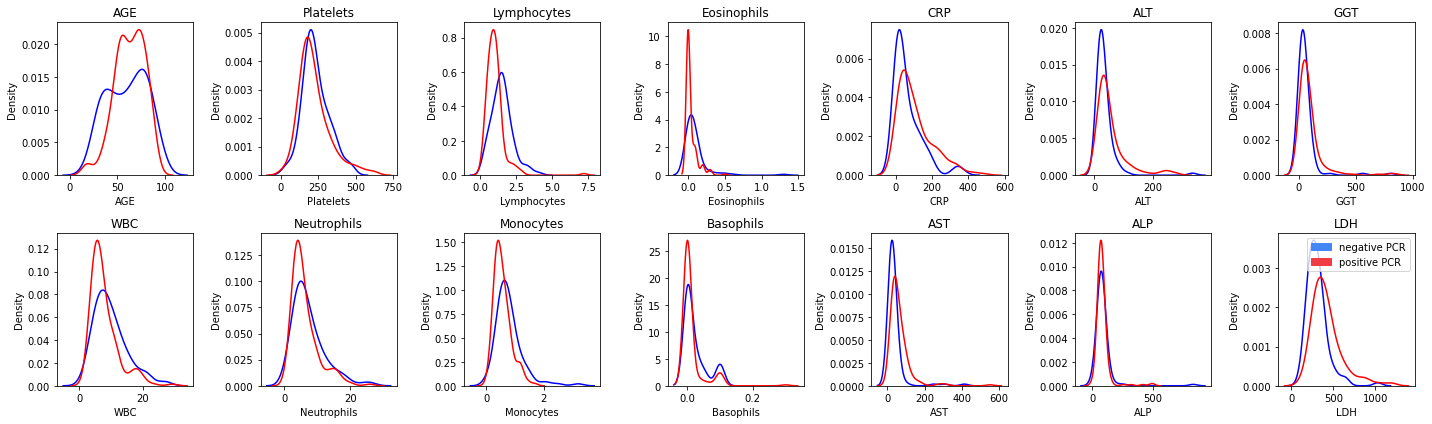

In [13]:
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='#4287f5', label='negative PCR')
red_patch = mpatches.Patch(color='#f03c45', label='positive PCR')
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(20,6))
for x in range(2,16):
    i = x % 2
    j = x // 2 - 1
    sns.kdeplot(imp_data[imp_data["SWAB"] == 0][imp_data.columns[x]], ax=axes[i,j], color="blue")
    sns.kdeplot(imp_data[imp_data["SWAB"] == 1][imp_data.columns[x]], ax=axes[i,j], color="red")
    axes[i,j].set_title(imp_data.columns[x])
plt.legend(handles=[blue_patch, red_patch])
plt.tight_layout()

In [12]:
from sklearn.impute import KNNImputer
knn_imp = KNNImputer(missing_values=np.nan)
knn_data = knn_imp.fit_transform(data)
knn_data = pd.DataFrame(knn_data, columns=data.columns)
knn_data.describe()

,female,male,AGE,WBC,Platelets,Neutrophils,Lymphocytes,Monocytes,Eosinophils,Basophils,CRP,AST,ALT,ALP,GGT,LDH,SWAB
count,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000
mean,0.326165,0.673835,61.819355,8.559355,226.658065,6.137061,1.181720,0.612760,0.057634,0.013477,90.581434,54.098925,45.101792,83.352688,72.996416,371.797849,0.634409
std,0.469651,0.469651,17.758923,4.840303,100.878446,3.776312,0.740352,0.368705,0.120067,0.034917,93.596677,57.418288,44.567885,64.475594,101.886832,174.703029,0.482461
min,0.000000,0.000000,18.000000,1.100000,20.000000,0.500000,0.200000,0.000000,0.000000,0.000000,0.100000,11.000000,9.000000,34.000000,10.000000,98.000000,0.000000
25%,0.000000,0.000000,49.000000,5.100000,163.500000,3.740000,0.700000,0.400000,0.000000,0.000000,21.800000,27.000000,22.000000,59.900000,27.100000,252.300000,0.000000
50%,0.000000,1.000000,64.000000,7.200000,205.000000,5.280000,1.000000,0.560000,0.000000,0.000000,54.500000,37.000000,32.000000,72.000000,42.400000,324.000000,1.000000
75%,1.000000,1.000000,76.000000,10.750000,271.500000,7.410000,1.400000,0.790000,0.100000,0.000000,129.100000,60.000000,47.000000,86.800000,82.800000,441.000000,1.000000
max,1.000000,1.000000,98.000000,29.200000,620.000000,26.400000,7.200000,3.200000,1.300000,0.300000,478.000000,550.000000,335.000000,838.000000,839.000000,1195.000000,1.000000


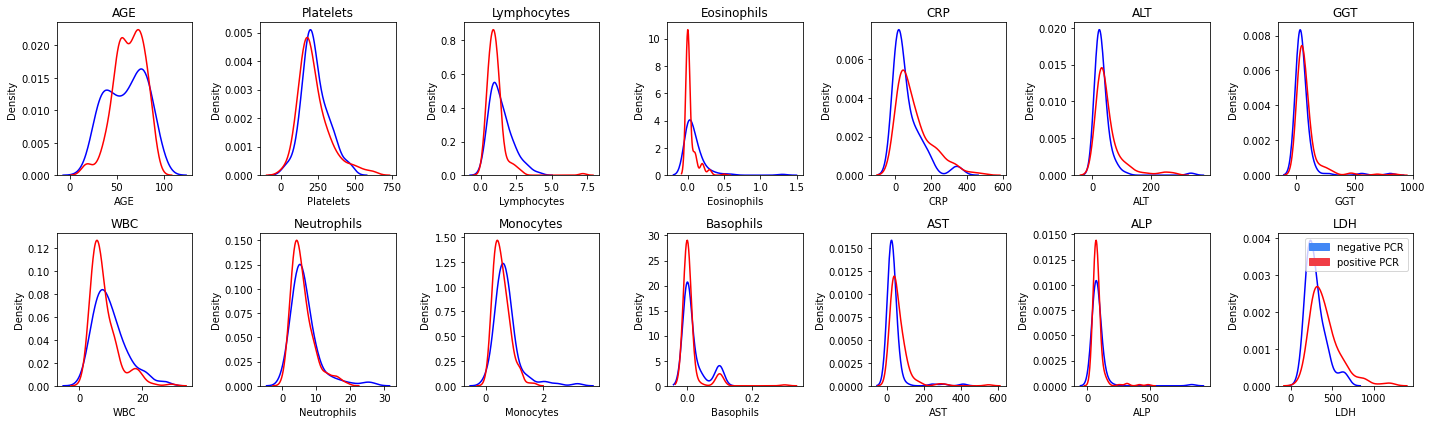

In [13]:
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='#4287f5', label='negative PCR')
red_patch = mpatches.Patch(color='#f03c45', label='positive PCR')
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(20,6))
for x in range(2,16):
    i = x % 2
    j = x // 2 - 1
    sns.kdeplot(knn_data[knn_data["SWAB"] == 0][knn_data.columns[x]], ax=axes[i,j], color="blue")
    sns.kdeplot(knn_data[knn_data["SWAB"] == 1][knn_data.columns[x]], ax=axes[i,j], color="red")
    axes[i,j].set_title(knn_data.columns[x])
plt.legend(handles=[blue_patch, red_patch])
plt.tight_layout()

### Model preparation

In [ ]:
# import all necessary tools
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

In [ ]:
X, y = data[data.columns[:-1]], data["SWAB"]
# prepare 5-fold nested cross validation by defining outer loop of nested cv
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
# question 1: paper states that missing data imputation done during nested cross validation,
# but Imputer has to be trained. Train it on whole dataset and then use it for every nested cross-validation subset or train it on subsets?
# start for loop by invoking cv_outer.split(X, y) to get indices for subsetting training and test data
for train_index, test_index in cv_outer.split(X, y):
    X_train, X_test = X[train_index,:], X[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    # do imputation here?
    # define inner loop of nested cross validation
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
    # instantiate model for hyperparameter search by means of GridSearch
    model = RandomForestClassifier(random_state=1)
    # define the search space over which GridSearch should; currently just sample values, need to be defined later
    space = {}
    space['n_estimators'] = [10, 100, 500]
    space['max_features'] = [2, 4, 6]
    # define GridSearch for nested cv
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    yhat = best_model.predict(X_test)
    # evaluate the model by means of accuracy, balanced accuracy, positive predictive value (PPV), sensitivity and AUC

[[1]](https://stats.stackexchange.com/questions/437487/cross-validation-and-multiple-imputation-for-missing-data) seems to indicate that training should happen on subset